# Checagem de vantagens transitórias para Nereu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

from utils_ccd import get_connection, get_info_file_path, extract_text_from_pdf

from langchain_openai import  AzureChatOpenAI
from langchain.prompts import PromptTemplate

conn = get_connection()

# Todos os débitos

In [2]:
sql_debitos_nereu_query = """
SELECT DISTINCT 
        ed.IdDebito as id_debito,
        gp.Documento,
        gp.Nome,
       CONCAT(pro_exe.numero_processo, '/', pro_exe.ano_processo) as processo_execucao,
       pro_orig.codigo_tipo_processo,
       pro_exe.assunto,
       etd.Descricao as tipo_multa,
       edmc.DataFinalImputacaoMultaCominatoria as data_final_cominatoria,
       CONCAT(gp.Nome, ' (CPF: ', gp.Documento, ')') as nome,
       processo.dbo.fn_Exe_RetornaValorAtualizado(ed.IdDebito) as valor_multa,
       r.nome as relator,
       ed.IdProcessoOrigem as id_processo_origem,
       (
        SELECT CONCAT(numero_processo, '/', ano_processo)
        FROM processo.dbo.Processos
        WHERE IdProcesso = ed.IdProcessoOrigem
       ) as processo_origem,
       pro_orig.codigo_tipo_processo as tipo_processo_origem,
       (
        SELECT o.nome
		FROM processo.dbo.Orgaos o
		WHERE o.IdOrgao = pro_orig.IdOrgaoEnvolvido
       ) as orgao_envolvido_processo_origem,
       ed.IdProcessoExecucao as id_processo_execucao,
       esd.DescricaoStatusDivida as status_divida
	FROM processo.dbo.Exe_Debito ed 
	LEFT JOIN processo.dbo.Processos pro_orig ON ed.IdProcessoOrigem = pro_orig.IdProcesso
	LEFT JOIN processo.dbo.Processos pro_exe ON ed.IdProcessoExecucao = pro_exe.IdProcesso
	LEFT JOIN processo.dbo.Relator r ON r.codigo = pro_exe.codigo_relator 
	LEFT JOIN processo.dbo.Exe_DebitoPessoa edp ON edp.IDDebito = ed.IdDebito
	LEFT JOIN processo.dbo.Exe_TipoDebito etd ON etd.CodigoTipoDebito = ed.CodigoTipoDebito
	LEFT JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = edp.IDPessoa
	LEFT JOIN processo.dbo.Exe_StatusDivida esd ON esd.CodigoStatusDivida = ed.CodigoStatusDivida
	LEFT JOIN processo.dbo.Exe_Debito_MultaCominatoria edmc ON ed.IdDebito = edmc.IdDebito
	WHERE gp.Documento = '13006444434'

"""
df_debitos_nereu = pd.read_sql(sql_debitos_nereu_query, conn)

/tmp/ipykernel_7396/2508274557.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_debitos_nereu = pd.read_sql(sql_debitos_nereu_query, conn)


In [3]:
df_debitos_nereu.columns

Index(['id_debito', 'Documento', 'Nome', 'processo_execucao',
       'codigo_tipo_processo', 'assunto', 'tipo_multa',
       'data_final_cominatoria', 'nome', 'valor_multa', 'relator',
       'id_processo_origem', 'processo_origem', 'tipo_processo_origem',
       'orgao_envolvido_processo_origem', 'id_processo_execucao',
       'status_divida'],
      dtype='object')

In [4]:
len(df_debitos_nereu)

649

In [5]:
processos_origem = df_debitos_nereu['processo_origem'].unique()

In [6]:
processos_busca = ', '.join(f"'{proc}'" for proc in processos_origem)

sql_all_informacoes_processos = f'''
SELECT concat(rtrim(inf.setor),'_',inf.numero_processo ,'_',inf.ano_processo,'_',RIGHT(concat('0000',inf.ordem),4),'.pdf') as arquivo,
ppe.SequencialProcessoEvento as evento,
CONCAT(inf.numero_processo,'/', inf.ano_processo) as processo,
inf.*
FROM processo.dbo.vw_ata_informacao inf INNER JOIN processo.dbo.Pro_ProcessoEvento ppe 
    ON inf.idinformacao = ppe.idinformacao
WHERE concat(inf.numero_processo, '/', inf.ano_processo) in ({processos_busca})
'''
all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)


/tmp/ipykernel_7396/22331079.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)


In [7]:
help(get_info_file_path)

Help on function get_info_file_path in module utils_ccd:

get_info_file_path(row, dir_info='\\\\10.24.0.6\\tce$\\Informacoes_PDF')



In [8]:
from functools import partial
get_info_file_path_partial = partial(get_info_file_path, dir_info='/media/informacoes_pdf/')

In [9]:
all_informacoes_processos['caminho_arquivo'] = all_informacoes_processos.apply(get_info_file_path_partial, axis=1)

In [10]:
all_informacoes_processos['caminho_arquivo']

0        /media/informacoes_pdf/DE/DE_017428_2012_0001.pdf
1        /media/informacoes_pdf/DAP/DAP_004605_2005_000...
2        /media/informacoes_pdf/PROC/PROC_008669_2010_0...
3        /media/informacoes_pdf/DE/DE_000593_2013_0008.pdf
4        /media/informacoes_pdf/PROC_CTJ/PROC_CTJ_01742...
                               ...                        
34350    /media/informacoes_pdf/DE_EXP/DE_EXP_026373_20...
34351    /media/informacoes_pdf/DE_EXP/DE_EXP_101863_20...
34352    /media/informacoes_pdf/DE_EXP/DE_EXP_101046_20...
34353    /media/informacoes_pdf/DE_EXP/DE_EXP_100439_20...
34354    /media/informacoes_pdf/CCD/CCD_006921_2016_007...
Name: caminho_arquivo, Length: 34355, dtype: object

In [11]:
all_informacoes_processos['resumo'].fillna('', inplace=True)

/tmp/ipykernel_7396/1279296039.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_informacoes_processos['resumo'].fillna('', inplace=True)


In [12]:
decisoes = f'''
SELECT numeroprocesso, anoprocesso, fundamentacaovoto, votoescolhido, ementa, texto_acordao, relatorio
FROM processo.dbo.vw_ia_votos_acordaos_decisoes
WHERE concat(numeroprocesso, '/', anoprocesso) in ({processos_busca})
AND VotoEscolhido = 1
'''
df_decisoes = pd.read_sql(decisoes, conn)

/tmp/ipykernel_7396/4069007640.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_decisoes = pd.read_sql(decisoes, conn)


In [13]:
df_decisoes.columns

Index(['numeroprocesso', 'anoprocesso', 'fundamentacaovoto', 'votoescolhido',
       'ementa', 'texto_acordao', 'relatorio'],
      dtype='object')

In [14]:
df_decisoes['processo'] = df_decisoes.apply(
    lambda x: f"{x['numeroprocesso']}/{x['anoprocesso']}", axis=1
)

In [15]:
df_decisoes[['processo', 'texto_acordao']]

,processo,texto_acordao
0,003146/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
1,003391/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
2,009430/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
3,012518/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
4,014111/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
...,...,...
555,005552/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
556,025465/2016,DECIDEM os Conselheiros do Tribunal de Contas ...
557,026700/2016,DECIDEM os Conselheiros do Tribunal de Contas ...
558,012211/2006,DECIDEM os Conselheiros do Tribunal de Contas ...


In [16]:
decisoes_grp = df_decisoes.groupby('processo').agg({
    'texto_acordao': lambda x: '\n'.join(x.dropna().astype(str)),
    'ementa': lambda x: '\n'.join(x.dropna().astype(str)),
    'relatorio': lambda x: '\n'.join(x.dropna().astype(str)),
    'fundamentacaovoto': lambda x: '\n'.join(x.dropna().astype(str)),
}).reset_index()

In [17]:
decisoes_grp.head()

,processo,texto_acordao,ementa,relatorio,fundamentacaovoto
0,000002/2016,"Vistos, relatados e discutidos estes autos, AC...",\r\nEMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PR...,O presente processo trata de aposentadoria con...,"Faz-se mister destacar, inicialmente, que já h..."
1,000197/2004,DECIDEM os Conselheiros do Tribunal de Contas ...,APOSENTADORIA. DENEGAÇÃO DO REGISTRO DA MATÉRI...,Versam os presentes autos sobre aposentadoria ...,Analisando a matéria sob os auspícios da legal...
2,000259/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata-se da análise do ato de aposentadoria co...,Pelo que se constata nos documentos acostados ...
3,000266/2017,"Vistos, relatados e discutidos estes autos, co...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...,O presente processo trata de aposentadoria con...,"Faz-se mister destacar, inicialmente, que já h..."
4,000301/2017,"Vistos, relatados e discutidos estes autos, ac...",EMENTA: Pessoal. Aposentadoria. Denegação do r...,Cuida-se da análise da legalidade da aposentad...,Convém mencionar que o retorno dos presentes a...


In [18]:
decisoes_grp.columns

Index(['processo', 'texto_acordao', 'ementa', 'relatorio',
       'fundamentacaovoto'],
      dtype='object')

In [19]:
def is_natureza_transitoria(ementa):
    if pd.isna(ementa):
        return False
    keywords = ['propter lab', 'natureza transit', 'vantagens transit', 'vantagem transit', 'insalubrida']
    return any(keyword in ementa.lower() for keyword in keywords)

In [20]:
decisoes_grp['verbas_transitorias'] = decisoes_grp['ementa'].apply(lambda x: 'Verba Transitória' if is_natureza_transitoria(x) else 'Outros assuntos')

<Axes: xlabel='verbas_transitorias'>

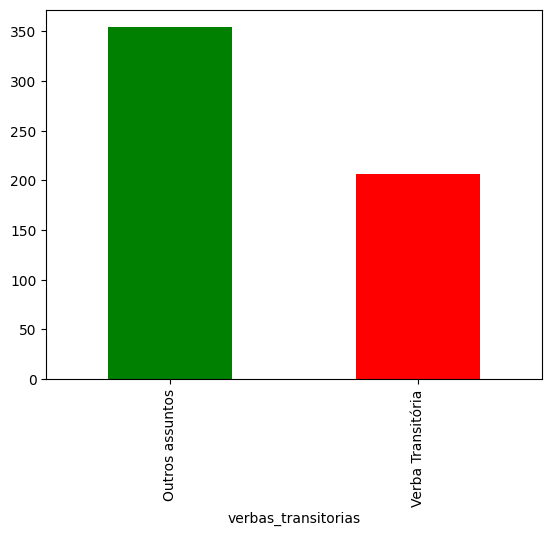

In [21]:
decisoes_grp['verbas_transitorias'].value_counts().plot(kind='bar', color=['green', 'red'])

In [22]:
llm = AzureChatOpenAI(model_name="gpt-4o")

def get_verba_voto(texto):
    try:
        prompt = PromptTemplate.from_template("""
        Você é um agente que analisa e categoriza votos de decisões do TCE/RN.
        Seu objetivo é decidir se o voto é sobre uma verba transitória ou não.
        Verbas transitórias são aquelas que possuem natureza transitória, como propter laborem, vantagens transitórias, insalubridade, etc.
        O texto do é o seguinte:
        "{input}"
                                              
        Encontre os trechos onde trata de verba transitória. Separe os trechos encontrados com uma quebra de linha.
        Se não encontrar, responda "Não há verba transitória mencionada no voto".
        
        Sua resposta:
        """)

        chain = prompt | llm
        msg_obj = chain.invoke(texto)
        return msg_obj.content
    except Exception as e:
        print(f"Error processing {texto}: {e}")
        return None
    


In [23]:
#decisoes_grp['trechos_verba_voto'] = decisoes_grp['fundamentacaovoto'].apply(get_verba_voto)
#decisoes_grp.to_excel('df_decisoes.xlsx', index=False)
decisoes_grp = pd.read_excel('df_decisoes.xlsx')

In [24]:
decisoes_grp

,processo,texto_acordao,ementa,relatorio,fundamentacaovoto,verbas_transitorias,trechos_verba_voto
0,000002/2016,"Vistos, relatados e discutidos estes autos, AC...",_x000D_\nEMENTA: CONSTITUCIONAL. ADMINISTRATIV...,O presente processo trata de aposentadoria con...,"Faz-se mister destacar, inicialmente, que já h...",Outros assuntos,"""não há verba transitória mencionada no voto."""
1,000197/2004,DECIDEM os Conselheiros do Tribunal de Contas ...,APOSENTADORIA. DENEGAÇÃO DO REGISTRO DA MATÉRI...,Versam os presentes autos sobre aposentadoria ...,Analisando a matéria sob os auspícios da legal...,Outros assuntos,"""Não há verba transitória mencionada no voto"""
2,000259/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata-se da análise do ato de aposentadoria co...,Pelo que se constata nos documentos acostados ...,Verba Transitória,"- ""esta Corte passou a resguardar o direito ad..."
3,000266/2017,"Vistos, relatados e discutidos estes autos, co...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...,O presente processo trata de aposentadoria con...,"Faz-se mister destacar, inicialmente, que já h...",Outros assuntos,Não há verba transitória mencionada no voto.
4,000301/2017,"Vistos, relatados e discutidos estes autos, ac...",EMENTA: Pessoal. Aposentadoria. Denegação do r...,Cuida-se da análise da legalidade da aposentad...,Convém mencionar que o retorno dos presentes a...,Outros assuntos,"""no tocante ao valor implantado indevidamente ..."
...,...,...,...,...,...,...,...
555,102523/2018,"Vistos, relatados e discutidos estes autos da ...",CONSTITUCIONAL. ADMINISTRATIVO. CONTROLE EXTER...,\tTrata-se de processo que tem por objeto a an...,"De início, ressalto que a matéria está sendo a...",Outros assuntos,```\nNa Informação Técnica emitida em 15/07/20...
556,102534/2018,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata-se da análise do ato de aposentadoria co...,Pelo que se constata nos documentos acostados ...,Verba Transitória,"""Pelo que se constata nos documentos acostados..."
557,102559/2018,"Vistos, relatados e discutidos estes autos, AC...",EMENTA: Constitucional. Administrativo. Aposen...,Cuida-se da análise da legalidade da aposentad...,Convém mencionar que o retorno dos presentes a...,Outros assuntos,"""no tocante a incorporação indevida de vantage..."
558,102602/2018,"Vistos, relatados e discutidos estes autos, ac...",EMENTA: Constitucional. Administrativo. Aposen...,Cuida-se da análise da legalidade da aposentad...,Convém mencionar que o retorno dos presentes a...,Outros assuntos,"""Convém mencionar que o retorno dos presentes ..."


In [25]:
votos_verba = decisoes_grp[decisoes_grp['trechos_verba_voto'] == 'Não há verba transitória mencionada no voto.']

In [26]:
print(votos_verba.iloc[0]["ementa"])

EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVIDENCIÁRIO. APOSENTADORIA.  VERIFICAÇÃO DE DESCUMPRIMENTO DE DECISÃO DESTE TCE. FLAGRANTE E INÉDITA MORA DO GESTOR RESPONSÁVEL PELO IPERN EM RELAÇÃO AO ATENDIMENTO DE EXPRESSIVO NÚMERO DE DETERMINAÇÕES DESTE TRIBUNAL, POR MAIS DE UM ANO. IMPOSIÇÃO DE MULTA POR DESCUMPRIMENTO, DIANTE DA CONDUTA OMISSIVA DO RESPONSÁVEL. PROCESSO NÃO ABRANGIDO PELO DE APURAÇÃO DE RESPONSABILDIADE Nº 003474/2021-TC INSTAURADO PARA LEVANTAMENTO DO DANO CAUSADO AO ERÁRIO PELO DESCUMPRIMENTO DE OUTRAS DECISÕES DESTA CORTE NOS ATOS DE PESSOAL DE COMPETÊNCIA DO IPERN, BEM COMO PARA IMPOSIÇÃO DE POSSÍVEIS SANÇÕES ADMINISTRATIVAS AO GESTOR OMISSO. RENOVAÇÃO DA DETERMINAÇÃO PARA QUE O GESTOR RESPONSÁVEL PELO IPERN ADOTE AS PROVIDÊNCIAS NECESSÁRIAS AO ATENDIMENTO DA DECISÃO, SOB PENA DE MULTA DIÁRIA DESDE JÁ FIXADA. DETERMINAÇÃO DE RESSARCIMENTO AO ERÁRIO, CUJO LEVANTAMENTO DOS VALORES DEVERÁ SER REALIZADO PELA DAP, SEGUINDO OS MESMOS PARÂMETROS UTILIZADOS NO PROC. Nº 003

In [27]:
#decisoes_grp.drop(columns=['categoria_ementa'], inplace=True)

In [28]:
sql_processos_origem = f'''
SELECT CONCAT(p.numero_processo, '/', p.ano_processo) as processo, gp.Documento as cpf, gp.Nome COLLATE SQL_Latin1_General_CP1_CI_AS as nome
FROM processo.dbo.Processos p INNER JOIN processo.dbo.Pro_ProcessosResponsavelDespesa pprd  ON p.IdProcesso = pprd.IdProcesso
INNER JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = pprd.IdPessoa 
WHERE CONCAT(p.numero_processo, '/', p.ano_processo) IN ({','.join([f"'{proc}'" for proc in processos_origem])})
AND gp.Documento NOT IN ('08242034000102', '13006444434') AND len(gp.Documento) = 11
'''
df_processos_origem = pd.read_sql(sql_processos_origem, conn)

/tmp/ipykernel_7396/595497275.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_processos_origem = pd.read_sql(sql_processos_origem, conn)


In [29]:
sql_pessoas_origem = f'''SELECT DISTINCT codigo_orgao, cpf
FROM BdDIP.dbo.vwSiaiPessoalFolhaResumida fr
WHERE fr.CPF IN ({','.join([f"'{cpf}'" for cpf in df_processos_origem['cpf'].unique()])}
)
AND fr.codigo_orgao NOT IN ('IPERN')
'''
df_pessoas_origem = pd.read_sql(sql_pessoas_origem, conn)


/tmp/ipykernel_7396/532772401.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pessoas_origem = pd.read_sql(sql_pessoas_origem, conn)


In [30]:
df_pessoas_origem = df_pessoas_origem.groupby('cpf').agg({
    'codigo_orgao': pd.Series.tolist
}).reset_index()

processos_orgaos = df_processos_origem.merge(
    df_pessoas_origem,
    how='left',
    left_on='cpf',
    right_on='cpf',
    suffixes=('', '_pessoas')
)[['processo', 'cpf', 'nome', 'codigo_orgao']]
processos_orgaos


processos_orgaos.dropna(subset=['codigo_orgao'], inplace=True)

In [31]:
processos_orgaos.rename(columns={'codigo_orgao': 'orgaos_servidores_envolvidos', 'nome': 'servidores_envolvidos'}, inplace=True)

In [32]:
processos_orgaos_grouped = processos_orgaos.groupby('processo').agg(lambda x: list(x)).reset_index()

In [33]:
processos_orgaos_grouped['orgaos_servidores_envolvidos'] = processos_orgaos_grouped['orgaos_servidores_envolvidos'].apply(
    lambda lst: [org for sublist in lst for org in sublist] if isinstance(lst, list) else lst
)

In [34]:
processos_orgaos = processos_orgaos_grouped

In [35]:
df_debitos_nereu.columns

Index(['id_debito', 'Documento', 'Nome', 'processo_execucao',
       'codigo_tipo_processo', 'assunto', 'tipo_multa',
       'data_final_cominatoria', 'nome', 'valor_multa', 'relator',
       'id_processo_origem', 'processo_origem', 'tipo_processo_origem',
       'orgao_envolvido_processo_origem', 'id_processo_execucao',
       'status_divida'],
      dtype='object')

In [36]:
tab_debitos = df_debitos_nereu[['id_debito', 'processo_origem', 'processo_execucao', 'orgao_envolvido_processo_origem', 'tipo_processo_origem', 'tipo_multa', 'valor_multa', 'relator', 'status_divida']]

In [37]:
tab_debitos = tab_debitos.merge(
    processos_orgaos,
    how='left',
    left_on='processo_origem',
    right_on='processo',
    suffixes=('', '_orgaos')
)[['id_debito', 'processo', 'processo_origem', 'processo_execucao', 'orgao_envolvido_processo_origem', \
   'tipo_processo_origem', 'tipo_multa', 'valor_multa', 'relator', 'status_divida',\
      'servidores_envolvidos', 'orgaos_servidores_envolvidos']]

In [38]:
tab_debitos = tab_debitos.merge(
    decisoes_grp,
    how='left',
    left_on='processo_origem',
    right_on='processo',
    suffixes=('', '_decisoes')
)

In [39]:
tab_debitos.columns

Index(['id_debito', 'processo', 'processo_origem', 'processo_execucao',
       'orgao_envolvido_processo_origem', 'tipo_processo_origem', 'tipo_multa',
       'valor_multa', 'relator', 'status_divida', 'servidores_envolvidos',
       'orgaos_servidores_envolvidos', 'processo_decisoes', 'texto_acordao',
       'ementa', 'relatorio', 'fundamentacaovoto', 'verbas_transitorias',
       'trechos_verba_voto'],
      dtype='object')

In [40]:
tab_debitos.drop(columns=['processo_decisoes'], inplace=True)
tab_debitos.rename(columns={
    'texto_acordao': 'texto_acordaos',
    'ementa': 'ementas_decisoes',
    'relatorio': 'relatorios_decisoes',
    'fundamentacaovoto': 'votos_decisoes',
}, inplace=True)

In [41]:
tab_debitos['servidores_envolvidos'].fillna('Sem servidores envolvidos', inplace=True)
tab_debitos['orgaos_servidores_envolvidos'].fillna('Sem órgãos envolvidos', inplace=True)
tab_debitos['texto_acordaos'].fillna('Sem decisões', inplace=True)
tab_debitos['ementas_decisoes'].fillna('Sem decisões', inplace=True)
tab_debitos['verbas_transitorias'].fillna('', inplace=True)

/tmp/ipykernel_7396/2124656794.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tab_debitos['servidores_envolvidos'].fillna('Sem servidores envolvidos', inplace=True)
/tmp/ipykernel_7396/2124656794.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[c

In [42]:
import locale

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

tab_debitos['valor_multa'] = tab_debitos['valor_multa'].apply(lambda x: locale.currency(x, grouping=True, symbol=False) if pd.notnull(x) else '0,00')

In [43]:
tab_debitos.drop(columns=['processo'], inplace=True)

In [44]:
tab_debitos

,id_debito,processo_origem,processo_execucao,orgao_envolvido_processo_origem,tipo_processo_origem,tipo_multa,valor_multa,relator,status_divida,servidores_envolvidos,orgaos_servidores_envolvidos,texto_acordaos,ementas_decisoes,relatorios_decisoes,votos_decisoes,verbas_transitorias,trechos_verba_voto
0,2760,007433/2005,001081/2015,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"136,58",RENATO COSTA DIAS,Cancelada por prescrição,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,NaN,NaN,,NaN
1,10979,002113/2009,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"118,11",None,Em Aberto,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,NaN,NaN,,NaN
2,19752,012078/2012,012970/2017,None,PAG,Multa,"9.858,52",CARLOS THOMPSON COSTA FERNANDES,Cancelada por Erro de Cadastro,[Maria das Graças Fernandes Costa da Motta],"[FUNDAC, SEARH]","Vistos, relatados e discutidos estes autos, em...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO E FINAN...,Cuida o presente feito do exame de pagamento r...,"No caso dos autos, imputa-se à gestora respons...",Outros assuntos,Não há verba transitória mencionada no voto.
3,19809,100897/2019,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"11.668,00",None,Cancelada por Erro de Cadastro,[MARIA LUCIA SALVIANO DE OLIVEIRA],"[SEARH, SESAP]","Vistos, relatados e discutidos estes autos de ...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"\tInicialmente, verifico que o retorno dos pre...",Outros assuntos,"```\n1. ""a qual determinou que a autoridade co..."
4,19810,101097/2019,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"11.750,84",None,Cancelada por Erro de Cadastro,[MARCOS ANTONIO BEZERRA CAVALCANTI],"[SEARH, SESAP]","Vistos, relatados e discutidos estes autos, em...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"Inicialmente, verifico que o retorno dos prese...",Outros assuntos,"""no tocante a incorporação indevida de vantage..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,28252,018875/2016,/,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,[MARIA DO ROZARIO DE SOUZA],"[PMTIBAU, SEARH, SESAP]","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL.ADMINISTRATIVO. APOSENT...,Trata o presente processo de monitoramento do ...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"- ""Em breve relato, depreende-se da análise da..."
645,28253,022595/2016,/,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,[SONIA MARIA VIEIRA],"[SEARH, SESAP]","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata o presente processo de monitoramento do ...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"""Em breve relato, depreende-se da análise da a..."
646,28259,019247/2016,/,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,[JOANA ROSALINA CAMPOS rodrigues],"[SEARH, SESAP]","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL.ADMINISTRATIVO. APOSENT...,Trata o presenteprocessode monitoramento docum...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"1. ""Em breve relato, depreende-se da análise d..."
647,28260,026373/2016,/,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,[FRANCISCA ADALGIZA FERNANDES DOS SANTOS],"[SEARH, SESAP]","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata o presente processo de monitoramento do ...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"""Em breve relato, depreende-se da análise da a..."


In [45]:
tab_debitos['orgaos_servidores_envolvidos'] = tab_debitos['orgaos_servidores_envolvidos'].apply(
    lambda lst: [org for sublist in lst for org in sublist] if isinstance(lst, list) and any(isinstance(i, list) for i in lst) else lst
)

In [46]:
tab_debitos['orgaos_servidores_envolvidos'] = tab_debitos['orgaos_servidores_envolvidos'].apply(
    lambda x: ', '.join(x) if isinstance(x, list) else x
)
tab_debitos['servidores_envolvidos'] = tab_debitos['servidores_envolvidos'].apply(
    lambda x: ', '.join(x) if isinstance(x, list) else x
)

In [47]:
tab_debitos

,id_debito,processo_origem,processo_execucao,orgao_envolvido_processo_origem,tipo_processo_origem,tipo_multa,valor_multa,relator,status_divida,servidores_envolvidos,orgaos_servidores_envolvidos,texto_acordaos,ementas_decisoes,relatorios_decisoes,votos_decisoes,verbas_transitorias,trechos_verba_voto
0,2760,007433/2005,001081/2015,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"136,58",RENATO COSTA DIAS,Cancelada por prescrição,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,NaN,NaN,,NaN
1,10979,002113/2009,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"118,11",None,Em Aberto,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,NaN,NaN,,NaN
2,19752,012078/2012,012970/2017,None,PAG,Multa,"9.858,52",CARLOS THOMPSON COSTA FERNANDES,Cancelada por Erro de Cadastro,Maria das Graças Fernandes Costa da Motta,"FUNDAC, SEARH","Vistos, relatados e discutidos estes autos, em...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO E FINAN...,Cuida o presente feito do exame de pagamento r...,"No caso dos autos, imputa-se à gestora respons...",Outros assuntos,Não há verba transitória mencionada no voto.
3,19809,100897/2019,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"11.668,00",None,Cancelada por Erro de Cadastro,MARIA LUCIA SALVIANO DE OLIVEIRA,"SEARH, SESAP","Vistos, relatados e discutidos estes autos de ...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"\tInicialmente, verifico que o retorno dos pre...",Outros assuntos,"```\n1. ""a qual determinou que a autoridade co..."
4,19810,101097/2019,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"11.750,84",None,Cancelada por Erro de Cadastro,MARCOS ANTONIO BEZERRA CAVALCANTI,"SEARH, SESAP","Vistos, relatados e discutidos estes autos, em...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"Inicialmente, verifico que o retorno dos prese...",Outros assuntos,"""no tocante a incorporação indevida de vantage..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,28252,018875/2016,/,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,MARIA DO ROZARIO DE SOUZA,"PMTIBAU, SEARH, SESAP","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL.ADMINISTRATIVO. APOSENT...,Trata o presente processo de monitoramento do ...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"- ""Em breve relato, depreende-se da análise da..."
645,28253,022595/2016,/,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,SONIA MARIA VIEIRA,"SEARH, SESAP","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata o presente processo de monitoramento do ...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"""Em breve relato, depreende-se da análise da a..."
646,28259,019247/2016,/,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,JOANA ROSALINA CAMPOS rodrigues,"SEARH, SESAP","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL.ADMINISTRATIVO. APOSENT...,Trata o presenteprocessode monitoramento docum...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"1. ""Em breve relato, depreende-se da análise d..."
647,28260,026373/2016,/,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,FRANCISCA ADALGIZA FERNANDES DOS SANTOS,"SEARH, SESAP","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata o presente processo de monitoramento do ...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"""Em breve relato, depreende-se da análise da a..."


In [48]:
tab_debitos['servidores_envolvidos'] = tab_debitos['servidores_envolvidos'].apply(
    lambda x: ', '.join(x) if isinstance(x, list) else x
)

In [49]:
tab_debitos

,id_debito,processo_origem,processo_execucao,orgao_envolvido_processo_origem,tipo_processo_origem,tipo_multa,valor_multa,relator,status_divida,servidores_envolvidos,orgaos_servidores_envolvidos,texto_acordaos,ementas_decisoes,relatorios_decisoes,votos_decisoes,verbas_transitorias,trechos_verba_voto
0,2760,007433/2005,001081/2015,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"136,58",RENATO COSTA DIAS,Cancelada por prescrição,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,NaN,NaN,,NaN
1,10979,002113/2009,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"118,11",None,Em Aberto,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,NaN,NaN,,NaN
2,19752,012078/2012,012970/2017,None,PAG,Multa,"9.858,52",CARLOS THOMPSON COSTA FERNANDES,Cancelada por Erro de Cadastro,Maria das Graças Fernandes Costa da Motta,"FUNDAC, SEARH","Vistos, relatados e discutidos estes autos, em...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO E FINAN...,Cuida o presente feito do exame de pagamento r...,"No caso dos autos, imputa-se à gestora respons...",Outros assuntos,Não há verba transitória mencionada no voto.
3,19809,100897/2019,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"11.668,00",None,Cancelada por Erro de Cadastro,MARIA LUCIA SALVIANO DE OLIVEIRA,"SEARH, SESAP","Vistos, relatados e discutidos estes autos de ...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"\tInicialmente, verifico que o retorno dos pre...",Outros assuntos,"```\n1. ""a qual determinou que a autoridade co..."
4,19810,101097/2019,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"11.750,84",None,Cancelada por Erro de Cadastro,MARCOS ANTONIO BEZERRA CAVALCANTI,"SEARH, SESAP","Vistos, relatados e discutidos estes autos, em...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"Inicialmente, verifico que o retorno dos prese...",Outros assuntos,"""no tocante a incorporação indevida de vantage..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,28252,018875/2016,/,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,MARIA DO ROZARIO DE SOUZA,"PMTIBAU, SEARH, SESAP","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL.ADMINISTRATIVO. APOSENT...,Trata o presente processo de monitoramento do ...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"- ""Em breve relato, depreende-se da análise da..."
645,28253,022595/2016,/,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,SONIA MARIA VIEIRA,"SEARH, SESAP","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata o presente processo de monitoramento do ...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"""Em breve relato, depreende-se da análise da a..."
646,28259,019247/2016,/,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,JOANA ROSALINA CAMPOS rodrigues,"SEARH, SESAP","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL.ADMINISTRATIVO. APOSENT...,Trata o presenteprocessode monitoramento docum...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"1. ""Em breve relato, depreende-se da análise d..."
647,28260,026373/2016,/,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,FRANCISCA ADALGIZA FERNANDES DOS SANTOS,"SEARH, SESAP","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata o presente processo de monitoramento do ...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"""Em breve relato, depreende-se da análise da a..."


In [50]:
def is_sesap(row):
    try:
        return 'SESAP' if 'SESAP' in row['orgaos_servidores_envolvidos'] or 'SAÚDE' in row['orgao_envolvido_processo_origem'] else 'OUTROS'
    except Exception as e:
        return 'OUTROS'

tab_debitos['sesap'] = tab_debitos.apply(is_sesap, axis=1)

In [53]:
tab_debitos['verbas_transitorias'] = tab_debitos['verbas_transitorias'].apply(lambda x: 'Inconclusivo' if x == '' else x)

In [55]:
tab_debitos['trechos_verba_voto'].fillna('', inplace=True)

In [56]:
tab_debitos['sesap'].value_counts() 

sesap
SESAP     545
OUTROS    104
Name: count, dtype: int64

In [57]:
tab_debitos['processo_execucao'] = tab_debitos['processo_execucao'].apply(lambda x: 'Sem processo de execução' if x == '/' else x )

In [58]:
tab_debitos.to_excel('debitos_processos_nereu.xlsx', index=False)

In [68]:
sesap_aberto_outros = tab_debitos[(tab_debitos['sesap'] == 'SESAP') & (tab_debitos['status_divida'].str.contains('Aberto')) & (tab_debitos['verbas_transitorias'] == 'Outros assuntos')]

In [93]:
sesap_voto_verba = sesap_aberto_outros[sesap_aberto_outros['trechos_verba_voto'] != 'Não há verba transitória mencionada no voto.']
sesap_outros = sesap_aberto_outros[sesap_aberto_outros['trechos_verba_voto'] == 'Não há verba transitória mencionada no voto.']
nao_sesap = tab_debitos[(tab_debitos['sesap'] == 'OUTROS') & (tab_debitos['status_divida'].str.contains('Aberto'))]

In [94]:
len(sesap_voto_verba), len(sesap_outros), len(nao_sesap)

(174, 104, 86)

In [96]:
sesap_outros

,id_debito,processo_origem,processo_execucao,orgao_envolvido_processo_origem,tipo_processo_origem,tipo_multa,valor_multa,relator,status_divida,servidores_envolvidos,orgaos_servidores_envolvidos,texto_acordaos,ementas_decisoes,relatorios_decisoes,votos_decisoes,verbas_transitorias,trechos_verba_voto,sesap
34,21602,001960/2016,000126/2022,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"13.002,90",ANTONIO ED SOUZA SANTANA,Em Aberto,MARIA DAS DORES ALMEIDA DA SILVA,SEARH,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata-se da análise do ato de aposentadoria co...,Pelo que se constata nos documentos acostados ...,Outros assuntos,Não há verba transitória mencionada no voto.,SESAP
55,21644,013849/2015,000123/2022,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"13.606,36",ANTONIO ED SOUZA SANTANA,Em Aberto,MARIA ILZA DA CONCEIÇÃO CAPISTRANO,"PMPORTALEG, SEARH, SESAP",DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata-se da análise do ato de aposentadoria co...,Pelo que se constata nos documentos acostados ...,Outros assuntos,Não há verba transitória mencionada no voto.,SESAP
63,21663,025465/2016,Sem processo de execução,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"13.838,41",None,Em Aberto,Marlene Freire de Sousa,SEARH,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata-se da análise do ato de aposentadoria co...,Pelo que se constata nos documentos acostados ...,Outros assuntos,Não há verba transitória mencionada no voto.,SESAP
76,21695,002757/2017,000117/2022,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"13.838,41",ANTONIO ED SOUZA SANTANA,Em Aberto,Marluce Costa,"SEARH, SESAP",DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata-se da análise do ato de aposentadoria co...,Pelo que se constata nos documentos acostados ...,Outros assuntos,Não há verba transitória mencionada no voto.,SESAP
94,22236,024593/2016,003074/2022,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.396,40",CARLOS THOMPSON COSTA FERNANDES,Em Aberto,ANTONIO ROBERTO RAMOS,"SEARH, SESAP","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...,O presente processo trata de aposentadoria con...,"Faz-se mister destacar, inicialmente, que já h...",Outros assuntos,Não há verba transitória mencionada no voto.,SESAP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,27636,014638/2016,Sem processo de execução,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.058,68",None,Em Aberto,MARIA DAS NEVES REBOUÇAS DE SOUSA,"PMNATAL, SEARH, SESAP","Vistos, relatados e discutidos estes autos, ac...",EMENTA: Constitucional. Administrativo. Aposen...,Cuida-se da análise da legalidade da aposentad...,Convém mencionar que o retorno dos presentes a...,Outros assuntos,Não há verba transitória mencionada no voto.,SESAP
561,27682,007462/2017,Sem processo de execução,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.054,04",None,Em Aberto,CICERA LÚCIA DE SOUZA,"SEARH, SESAP","Vistos, relatados e discutidos estes autos, ac...",EMENTA: Constitucional. Administrativo. Aposen...,Cuida-se da análise da legalidade da aposentad...,Convém mencionar que o retorno dos presentes a...,Outros assuntos,Não há verba transitória mencionada no voto.,SESAP
631,28166,008707/2017,Sem processo de execução,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.126,96",None,Em Aberto,LETICE SOARES DE LIMA SANTIAGO,SEARH,"Vistos, relatados e discutidos estes autos, ac...",EMENTA: Pessoal. Aposentadoria. Denegação do r...,Cuida-se da análise da legalidade da aposentad...,Convém mencionar que o retorno dos presentes a...,Outros assuntos,Não há verba transitória mencionada no voto.,SESAP
639,28247,010937/2017,Sem processo de execução,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,FRANCISCA NOGUEIRA D

In [105]:
len(sesap_outros['processo_origem'].unique())

104

In [109]:
info_decisoes_sesap_outros = all_informacoes_processos[(all_informacoes_processos['processo'].isin(sesap_outros['processo_origem'])) & \
                          (all_informacoes_processos['resumo'].str.contains('decisão', case=False, na=False)) &\
                            (all_informacoes_processos['setor'].str.contains('secss', case=False, na=False))]

In [106]:
with pd.ExcelWriter('analise_debitos_nereu.xlsx') as writer:
    tab_debitos.to_excel(writer, sheet_name='TodosDebitos', index=False)
    sesap_voto_verba.to_excel(writer, sheet_name='SesapVerbaTransitoria', index=False)
    sesap_outros.to_excel(writer, sheet_name='SesapOutrosAssuntos', index=False)
    nao_sesap.to_excel(writer, sheet_name='OutrosOrgaos', index=False)

In [132]:
teste = sesap_outros[sesap_outros['processo_origem'] == '007462/2017']

In [133]:
print(teste['votos_decisoes'].iloc[0])

Convém mencionar que o retorno dos presentes autos a esta Corte de Contas se deu em razão da Decisão nº 2664/2020 – TC, que determinou que a autoridade competente corrigisse o ato aposentador, retroagindo corretamente os efeitos da aposentadoria para a data limite de permanência da servidora no serviço público, afastando, assim, a incidência da aposentadoria compulsória, nos moldes do parágrafo único, do artigo 45, da Lei Complementar Estadual nº 308/2005._x000D_
Em suas análises, o Corpo Instrutivo da DAP e o Ministério Público de Contas ponderaram que a decisão proferida por este Tribunal não foi cumprida._x000D_
À vista disso, manifestaram pela cominação de multa a autoridade responsável em razão do descumprimento da referida decisão, assim como multa diária em face da inércia e da falta de justificativa do Instituto de Previdência dos Servidores do Estado do Rio Grande do Norte – IPERN. Por fim, o Parquet de Contas requereu a intimação do órgão previdenciário estadual, para cumprim

In [115]:
import shutil
for arquivo in info_decisoes_sesap_outros['caminho_arquivo'].unique():
    #download the PDF file
    shutil.copy(arquivo, 'saidas/decisoes_nereu/' + str(arquivo).split('/')[-1])

In [123]:
import fitz  # PyMuPDF
import os

pdf_dir = 'saidas/decisoes_nereu/'
output_pdf = 'decisoes_sesap_outros.pdf'

pdf_files = sorted([os.path.join(pdf_dir, f) for f in os.listdir(pdf_dir) if f.lower().endswith('.pdf')])

merged = fitz.open()
for pdf in pdf_files:
    doc = fitz.open(pdf)
    merged.insert_pdf(doc)
    doc.close()

merged.save(output_pdf)
merged.close()


In [122]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 38.2 MB/s eta 0:00:00m eta 0:00:010:01:01


# Somente implementadas

In [12]:
implementacoes = pd.read_excel('implementacoes_nereu.xlsx')
implementacoes['numero_processo'] = implementacoes['numero_processo'].apply(lambda x: str(x).zfill(6))
implementacoes['processo'] = implementacoes['numero_processo'] + '/' + implementacoes['ano_processo'].astype(str)

In [13]:
implementacoes['data_implementacao'] = pd.to_datetime(implementacoes['data_implementacao'], format='%d/%m/%Y', errors='coerce').dt.strftime('%m/%Y')


In [15]:
sql_nereu = f'''
SELECT DISTINCT 
        pro.numero_processo,
       pro.ano_processo,
       pro.assunto,
       pro.codigo_tipo_processo,
       (
        SELECT CONCAT(numero_processo, '/', ano_processo)
        FROM processo.dbo.Processos
        WHERE IdProcesso = ed.IdProcessoOrigem
       ) as processo_origem,
       ed.IdProcessoExecucao as id_processo_execucao,
       (
       SELECT CONCAT(numero_processo, '/', ano_processo)
        FROM processo.dbo.Processos
        WHERE IdProcesso = ed.IdProcessoExecucao
       ) as processo_execucao
	FROM processo.dbo.Processos pro
	INNER JOIN processo.dbo.Pro_MarcadorProcesso pmp ON pmp.IdProcesso = pro.IdProcesso
	INNER JOIN processo.dbo.Pro_Marcador pm ON pmp.IdMarcador = pm.IdMarcador
	INNER JOIN processo.dbo.Relator r ON r.codigo = pro.codigo_relator 
	LEFT JOIN processo.dbo.Exe_Debito ed ON ed.IdProcessoExecucao = pro.IdProcesso
	LEFT JOIN processo.dbo.Exe_DebitoPessoa edp ON edp.IDDebito = ed.IdDebito
	LEFT JOIN processo.dbo.Exe_TipoDebito etd ON etd.CodigoTipoDebito = ed.CodigoTipoDebito
	LEFT JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = edp.IDPessoa
	LEFT JOIN processo.dbo.Exe_Debito_MultaCominatoria edmc ON ed.IdDebito = edmc.IdDebito
	WHERE pro.setor_atual = 'CCD'
	AND CONCAT(pro.numero_processo, '/', pro.ano_processo) IN ({','.join(["'" + x + "'" for x in implementacoes['processo'].tolist()])})
'''
df_vantagens = pd.read_sql(sql_nereu, conn)

/tmp/ipykernel_17639/2322257977.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_vantagens = pd.read_sql(sql_nereu, conn)


In [16]:
processos_origem = df_vantagens['processo_origem'].dropna().unique()

In [17]:
processos_origem

array(['011198/2017', '014157/2016', '015126/2016', '001390/2017',
       '012528/2016', '012961/2016', '023839/2016', '011818/2017',
       '006180/2016', '003493/2017', '006602/2016', '000337/2016',
       '000348/2016', '003205/2017', '009063/2017', '012540/2017',
       '012706/2016', '016807/2017', '005209/2016', '017667/2016',
       '003279/2017', '016419/2017', '026556/2016', '006161/2016',
       '014151/2016', '020069/2016', '024961/2016', '003275/2017',
       '004160/2016', '010477/2017', '008568/2017', '006600/2016',
       '023221/2016', '024593/2016', '003226/2017', '003282/2017',
       '003383/2017', '014683/2017', '003235/2017', '006949/2016',
       '014113/2017', '024690/2016'], dtype=object)

In [18]:
processos_busca = ', '.join(f"'{proc}'" for proc in processos_origem)

sql_all_informacoes_processos = f'''
SELECT concat(rtrim(inf.setor),'_',inf.numero_processo ,'_',inf.ano_processo,'_',RIGHT(concat('0000',inf.ordem),4),'.pdf') as arquivo,
ppe.SequencialProcessoEvento as evento,
CONCAT(inf.numero_processo,'/', inf.ano_processo) as processo,
inf.*
FROM processo.dbo.vw_ata_informacao inf INNER JOIN processo.dbo.Pro_ProcessoEvento ppe 
    ON inf.idinformacao = ppe.idinformacao
WHERE concat(inf.numero_processo, '/', inf.ano_processo) in ({processos_busca})
'''
all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)
all_informacoes_processos['caminho_arquivo'] = all_informacoes_processos.apply(get_info_file_path, axis=1)


/tmp/ipykernel_17639/816184275.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)


In [ ]:
all_informacoes_processos['resumo'].fillna('', inplace=True)
all_informacoes_processos[all_informacoes_processos['resumo'].str.contains('DECIS')]['resumo']
all_informacoes_processos[all_informacoes_processos['resumo'].str.contains('decis')]['resumo'].values

218     MANDADO DE INTIMAÇÃO PARA COMUNICAÇÃO DA DECIS...
294     MANDADO DE INTIMAÇÃO PARA COMUNICAÇÃO DA DECIS...
325                                        DECISÃO PADRÃO
331                                        DECISÃO PADRÃO
354     MANDADO DE INTIMAÇÃO PARA CONHECIMENTO DE DECI...
                              ...                        
2796    MANDADO DE CITAÇÃO COM VISTAS AO CUMPRIMENTO D...
2799    MANDADO DE INTIMAÇÃO PARA CONHECIMENTO DE DECI...
2811    MANDADO DE CITAÇÃO COM VISTAS AO CUMPRIMENTO D...
2816    MANDADO DE INTIMAÇÃO PARA CONHECIMENTO DE DECI...
2820    MANDADO DE CITAÇÃO COM VISTAS AO CUMPRIMENTO D...
Name: resumo, Length: 287, dtype: object

array(['PEDIDO DE RECONSIDERAÇÃO. CONHECIMENTO. ATO COMPLEXO. VANTAGENS TRANSITÓRIAS. NATUREZA PROPTER LABOREM.  DESPROVIMENTO DO RECURSO.\r\nI - O pedido de reconsideração está de acordo com o artigo 376 do Regimento Interno do Tribunal de Contas, motivo pelo qual deve ser conhecido.\r\nII - Não infirmadas as razões da decisão, por meio de argumentos ou fatos aptos a impor a sua alteração, o pedido de reconsideração não merece provimento.\r\nIII - Opina-se pela manutenção integral do acórdão recorrido.\r\n'],
      dtype=object)

In [157]:
decisoes = f'''
SELECT *
FROM processo.dbo.vw_ia_votos_acordaos_decisoes
WHERE concat(numeroprocesso, '/', anoprocesso) in ({processos_busca})
'''
df_decisoes = pd.read_sql(decisoes, conn)

/tmp/ipykernel_87762/2911930637.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_decisoes = pd.read_sql(decisoes, conn)


In [158]:
df_decisoes.columns

Index(['idvoto', 'codigo_tipo_processo', 'descricao', 'TipoVoto',
       'VotoEscolhido', 'idInformacao_voto', 'INFO_arquivo_Voto',
       'IdComposicaoPauta', 'CodigoCamara', 'numero_sessao', 'ano_sessao',
       'DataSessao', 'numeroResultado', 'anoResultado', 'resultadoTipo',
       'IdApreciacao', 'idTipoRecurso', 'IdTipoVotacao', 'decisao',
       'idVotoPauta', 'idVotoDecisao', 'NomeRelator', 'Setor', 'ementa',
       'assunto', 'NumeroProcesso', 'AnoProcesso', 'NomeRelatorProcesso',
       'IdProcesso', 'OrgaoOrigem', 'interessado', 'Divergente_de_idVoto',
       'isVotoDivergente', 'IdVotoConcordado', 'Relatorio',
       'FundamentacaoVoto', 'Conclusao', 'texto_acordao', 'SetorVoto',
       'DescricaoTipoVoto'],
      dtype='object')

In [159]:
df_decisoes['processo'] = df_decisoes.apply(
    lambda x: f"{x['NumeroProcesso']}/{x['AnoProcesso']}", axis=1
)

In [160]:
df_decisoes[['processo', 'texto_acordao']]

,processo,texto_acordao
0,001390/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
1,003226/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
2,003235/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
3,003275/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
4,003279/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
...,...,...
78,026556/2016,"Vistos, relatados e discutidos estes autos, A..."
79,003275/2017,"Vistos, relatados e discutidos estes autos, ac..."
80,003235/2017,"Vistos, relatados e discutidos estes autos, AC..."
81,003279/2017,"Vistos, relatados e discutidos estes autos, AC..."


In [161]:
decisoes_grp = df_decisoes.groupby('processo').agg({
    'texto_acordao': lambda x: '\n'.join(x.dropna().astype(str)),
    'ementa': lambda x: '\n'.join(x.dropna().astype(str))
}).reset_index()

In [162]:
decisoes_grp

,processo,texto_acordao,ementa
0,000337/2016,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
1,000348/2016,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
2,001390/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
3,003205/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
4,003226/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
5,003235/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
6,003275/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
7,003279/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
8,003282/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
9,003383/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...


In [163]:
decisoes_grp['verbas_transitorias'] = decisoes_grp['ementa'].apply(lambda x: 'SIM' if 'PROPTER LA' in x else 'NÃO')

In [164]:
df_vantagens

,numero_processo,ano_processo,assunto,codigo_tipo_processo,processo_origem,id_processo_execucao,processo_execucao
0,000092,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,011198/2017,576947,000092/2023
1,000093,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,014157/2016,576948,000093/2023
2,000094,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,015126/2016,576949,000094/2023
3,000096,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,001390/2017,576951,000096/2023
4,000098,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,012528/2016,576953,000098/2023
5,000099,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,012961/2016,576954,000099/2023
6,000100,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,023839/2016,576955,000100/2023
7,000103,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,011818/2017,577183,000103/2023
8,000105,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,006180/2016,577275,000105/2023
9,000106,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,003493/2017,577278,000106/2023


In [165]:
decisoes_grp = decisoes_grp.merge(df_vantagens[['processo_execucao', 'processo_origem']], how='left', left_on='processo', right_on='processo_origem', suffixes=('', '_vantagens'))


In [166]:
tab_nereu = implementacoes.merge(
    decisoes_grp,
    left_on='processo',
    right_on='processo_execucao',
    how='left'
)
tab_nereu.drop(columns=['processo_x', 'processo_y', 
                        'processo_execucao'], inplace=True)

In [20]:
tab_nereu = pd.read_excel('processos_descontos_nereu.xlsx')

In [22]:
processos_origem = tab_nereu['processo_origem']

In [ ]:
sql_pessoas_origem = f'''SELECT DISTINCT codigo_orgao, cpf
FROM BdDIP.dbo.vwSiaiPessoalFolhaResumida fr
WHERE fr.CPF IN (
SELECT gp.Documento COLLATE SQL_Latin1_General_CP1_CI_AS
FROM processo.dbo.Processos p INNER JOIN processo.dbo.Pro_ProcessosResponsavelDespesa pprd  ON p.IdProcesso = pprd.IdProcesso
INNER JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = pprd.IdPessoa 
WHERE CONCAT(p.numero_processo, '/', p.ano_processo) IN ({','.join([f"'{proc}'" for proc in processos_origem])})
AND gp.Documento NOT IN ('08242034000102', '13006444434') AND len(gp.Documento) = 11
)
AND fr.codigo_orgao NOT IN ('IPERN')
'''
df_pessoas_origem = pd.read_sql(sql_pessoas_origem, conn)
sql_processos_origem = f'''
SELECT CONCAT(p.numero_processo, '/', p.ano_processo) as processo, gp.Documento as cpf, gp.Nome COLLATE SQL_Latin1_General_CP1_CI_AS as nome
FROM processo.dbo.Processos p INNER JOIN processo.dbo.Pro_ProcessosResponsavelDespesa pprd  ON p.IdProcesso = pprd.IdProcesso
INNER JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = pprd.IdPessoa 
WHERE CONCAT(p.numero_processo, '/', p.ano_processo) IN ({','.join([f"'{proc}'" for proc in processos_origem])})
AND gp.Documento NOT IN ('08242034000102', '13006444434') AND len(gp.Documento) = 11
'''
df_processos_origem = pd.read_sql(sql_processos_origem, conn)

In [ ]:
df_pessoas_origem = df_pessoas_origem.groupby('cpf').agg({
    'codigo_orgao': pd.Series.tolist
}).reset_index()

processos_orgaos = df_processos_origem.merge(
    df_pessoas_origem,
    how='left',
    left_on='cpf',
    right_on='cpf',
    suffixes=('', '_pessoas')
)[['processo', 'cpf', 'nome', 'codigo_orgao']]
processos_orgaos


processos_orgaos.dropna(subset=['codigo_orgao'], inplace=True)

processos_orgaos['saude?'] = processos_orgaos.codigo_orgao.apply(lambda x: 'SAÚDE' if 'SESAP' in x else 'OUTROS') 

/tmp/ipykernel_17639/472299046.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pessoas_origem = pd.read_sql(sql_pessoas_origem, conn)


In [94]:
tab_nereu = tab_nereu.merge(processos_orgaos[['processo', 'saude?']], right_on='processo', left_on='processo_origem', how='left')

In [99]:
tab_nereu.columns

Index(['numero_processo', 'ano_processo', 'valor_implementado',
       'data_implementacao', 'processo_sei', 'relator', 'obs',
       'textos_acordaos_processo', 'ementas_decisoes_processo',
       'verbas_transitorias', 'processo_origem', 'saude?'],
      dtype='object')

In [100]:
tab_nereu.to_excel('processos_descontos_nereu.xlsx', index=False)

In [168]:
tab_nereu.rename(columns={
    'texto_acordao': 'textos_acordaos_processo',
    'ementa': 'ementas_decisoes_processo'
}, inplace=True)

In [169]:
tab_nereu.to_excel('processos_descontos_nereu.xlsx', index=False)